In [7]:
from io import StringIO
import requests as req
from datetime import datetime, timezone
import json

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

In [2]:
session = req.Session()

In [3]:
def login(req_session: req.Session):
    url = 'https://idwr-groundwater-data.idaho.gov/KiWebPortal/rest/auth/login'
    login_request = {
        'userName': 'public',
        'password': 'public123'
    }
    headers = {
        'Content-Type': 'application/json',
    }
    request_payload = json.dumps(login_request)
    response = req_session.post(url, data=request_payload, headers=headers)
    response.raise_for_status()

def download_data(req_session: req.Session, start_date: datetime, end_date: datetime, is_transducer: bool):
    if 'wpl' not in req_session.cookies:
        login(req_session)

    base_url = 'https://idwr-groundwater-data.idaho.gov/KiWebPortal/rest/wiski7/dataSources/0/timeSeries/data'
    if is_transducer:
        ts_path = '16001/04N_02E_29ACC1/Comp_DTW/DTW.Compiled_PT'
    else:
        ts_path = '16001/04N_02E_29ACC1/Disc_DTW/DTW.Published'
    ts_params = {
        'format': 'csv',
        'ts_path': ts_path,
        'from': start_date.astimezone(timezone.utc).isoformat(timespec='milliseconds').replace('+00:00', 'Z'),
        'to': end_date.astimezone(timezone.utc).isoformat(timespec='milliseconds').replace('+00:00', 'Z')
    }
    request_params = {
        'params': json.dumps(ts_params)
    }
    response = req_session.get(base_url, params=request_params)
    response.raise_for_status()

    return response.text

def get_timeseries(req_session: req.Session, start_date: datetime, end_date: datetime):
    transducer_data = download_data(req_session, start_date, end_date, True)
    published_data = download_data(req_session, start_date, end_date, False)

    # Convert to DataFrames
    df1 = pd.read_csv(StringIO(transducer_data), comment='#', sep=';', header=None, names=['DateTime', 'Transducer'], parse_dates=['DateTime']).set_index('DateTime').sort_index()
    df2 = pd.read_csv(StringIO(published_data), comment='#', sep=';', header=None, names=['DateTime', 'Published'], parse_dates=['DateTime']).set_index('DateTime').sort_index()
    # Combine DataFrames
    combined_data = pd.concat([df1, df2], axis=0)

    return combined_data

In [4]:
timeseries_df = get_timeseries(session, start_date=datetime(2001, 10, 3, 6, 0, 0), end_date=datetime.now())

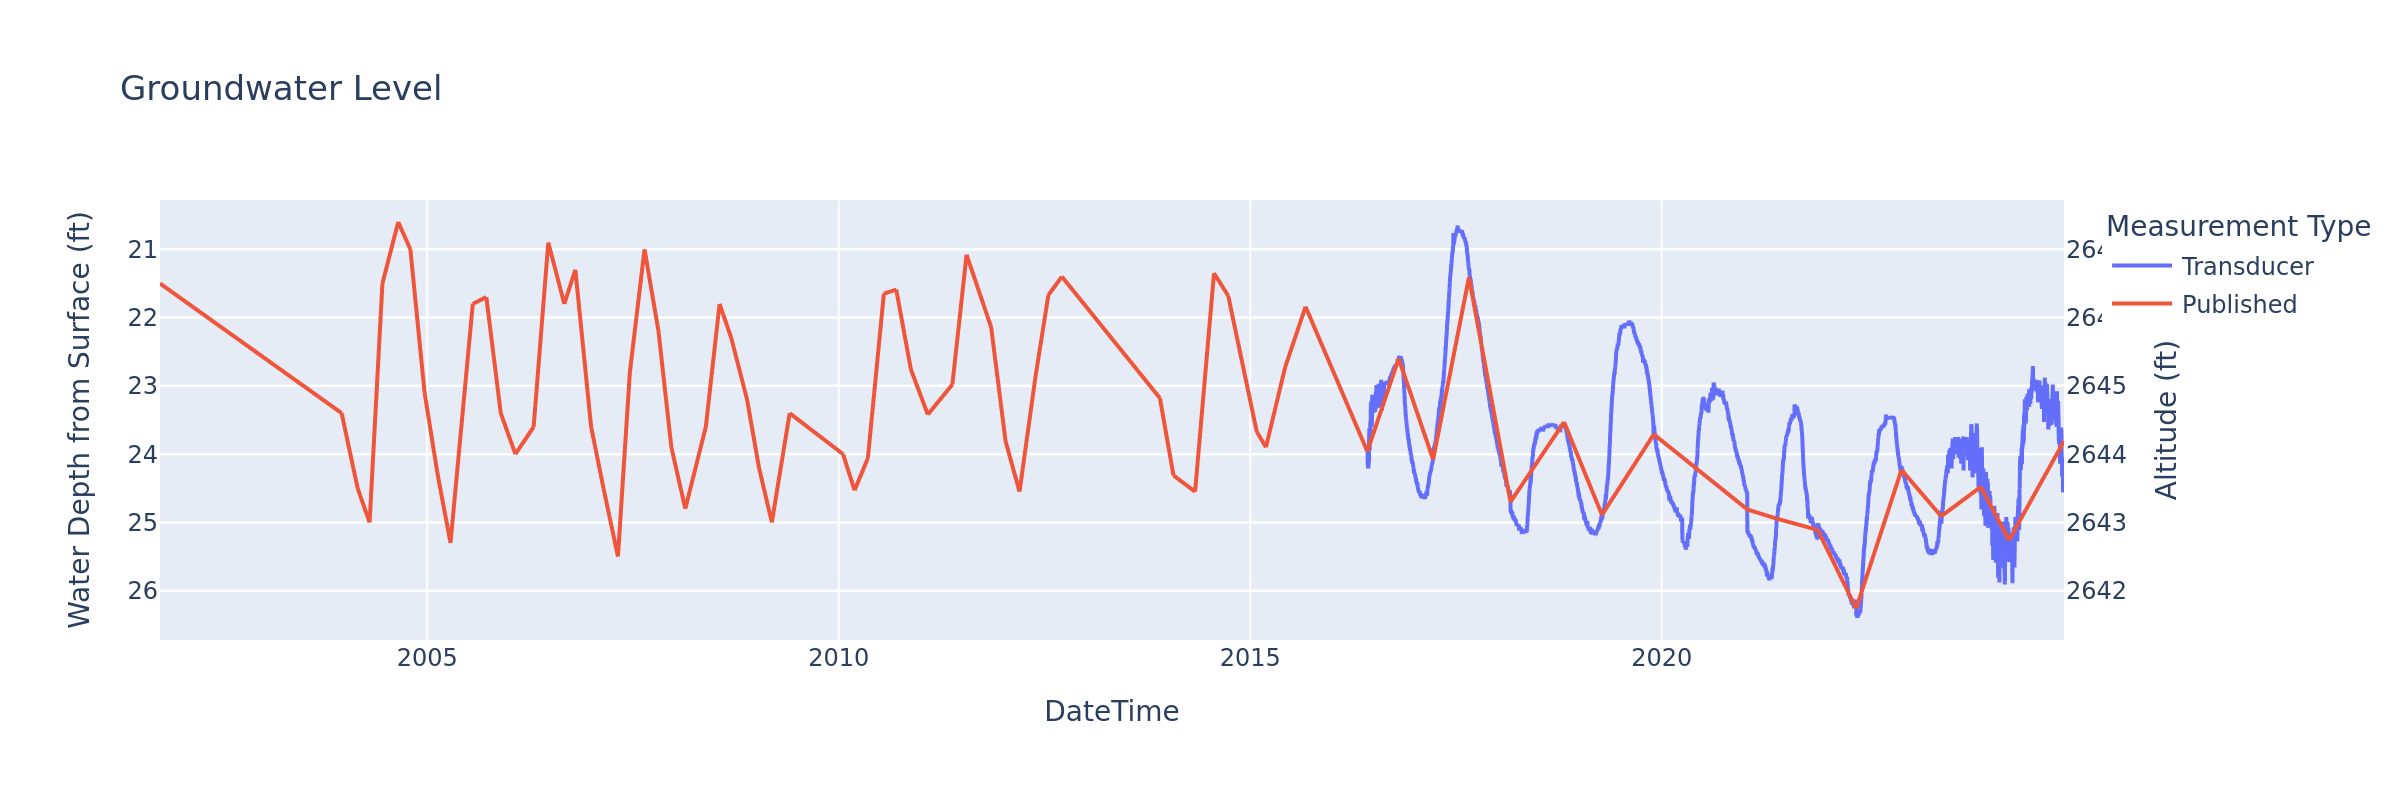

In [11]:
# Plot the Groundwater level
fig = px.line(timeseries_df, x=timeseries_df.index, y=timeseries_df.columns, title='Groundwater Level', labels={'value': 'Water Depth from Surface (ft)', 'variable': 'Measurement Type'})
fig.update_yaxes(autorange="reversed")

# Update each primary trace to include altitude as custom data 
for trace, col in zip(fig.data, timeseries_df.columns):
    altitude = 2668 - timeseries_df[col]
    trace.customdata = np.column_stack([altitude])
    trace.hovertemplate = (
        "Water Level: %{y:.1f} ft<br>" +
        "Altitude: %{customdata[0]:.1f} ft<extra></extra>"
    )

# Add invisible secondary traces for each column to force display of the right y-axis.
for col in timeseries_df.columns:
    fig.add_trace(
        go.Scatter(
            x=timeseries_df.index, 
            y=2668 - timeseries_df[col],
            mode='lines',
            name=f"{col} Altitude",
            yaxis="y2",
            line=dict(color='rgba(0,0,0,0)'),  # Fully transparent
            showlegend=False,
            hoverinfo="skip"  # Disable hover on these traces
        )
    )

fig.update_layout(
    yaxis2=dict(
        title="Altitude (ft)",
        overlaying="y",
        side="right",
    ),
    hovermode="closest"  # Use closest so only the primary traces are used for hover
)

img = fig.to_image(format='png', width=1200, height=400, scale=2)
Image(img)